This is a data science notebook of using machine learning to predict whether customers are deserving of credit yes or no

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-risk-customers/credit_customers.csv


In [2]:
df = pd.read_csv('/kaggle/input/credit-risk-customers/credit_customers.csv')

In [3]:
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Exploratory Data Analysis

In [4]:
# df = pd.concat([X_train, y_train], axis=1)
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


**Nulls and datatypes**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

**Numerical distributions**

In [6]:
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


Maxes & mins look reasonable

**Target Distribution**

<AxesSubplot: xlabel='class', ylabel='count'>

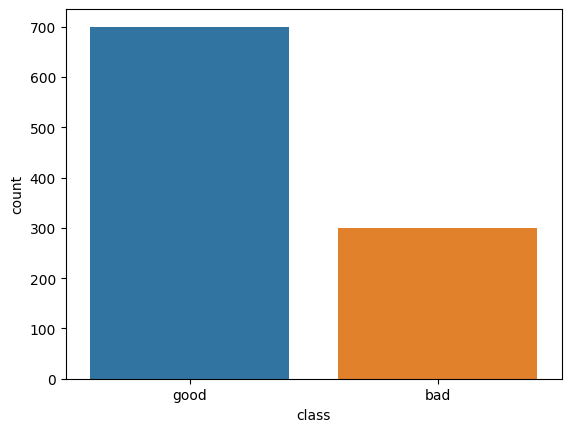

In [7]:
sns.countplot(x='class', data=df)

Majority of classifications (the target variable) are good, may have to take in over/undersampling

**Duplicates**

In [8]:
print(f'Duplicates in train set: {df.duplicated().sum()}, ({np.round(100*df.duplicated().sum()/len(df),1)}%)')

Duplicates in train set: 0, (0.0%)


**Categorical features**

In [9]:
categorical_columns=['checking_status', 'credit_history', 'purpose', 'savings_status', 
                  'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans'
                  , 'housing', 'job', 'own_telephone', 'foreign_worker'
                 ]

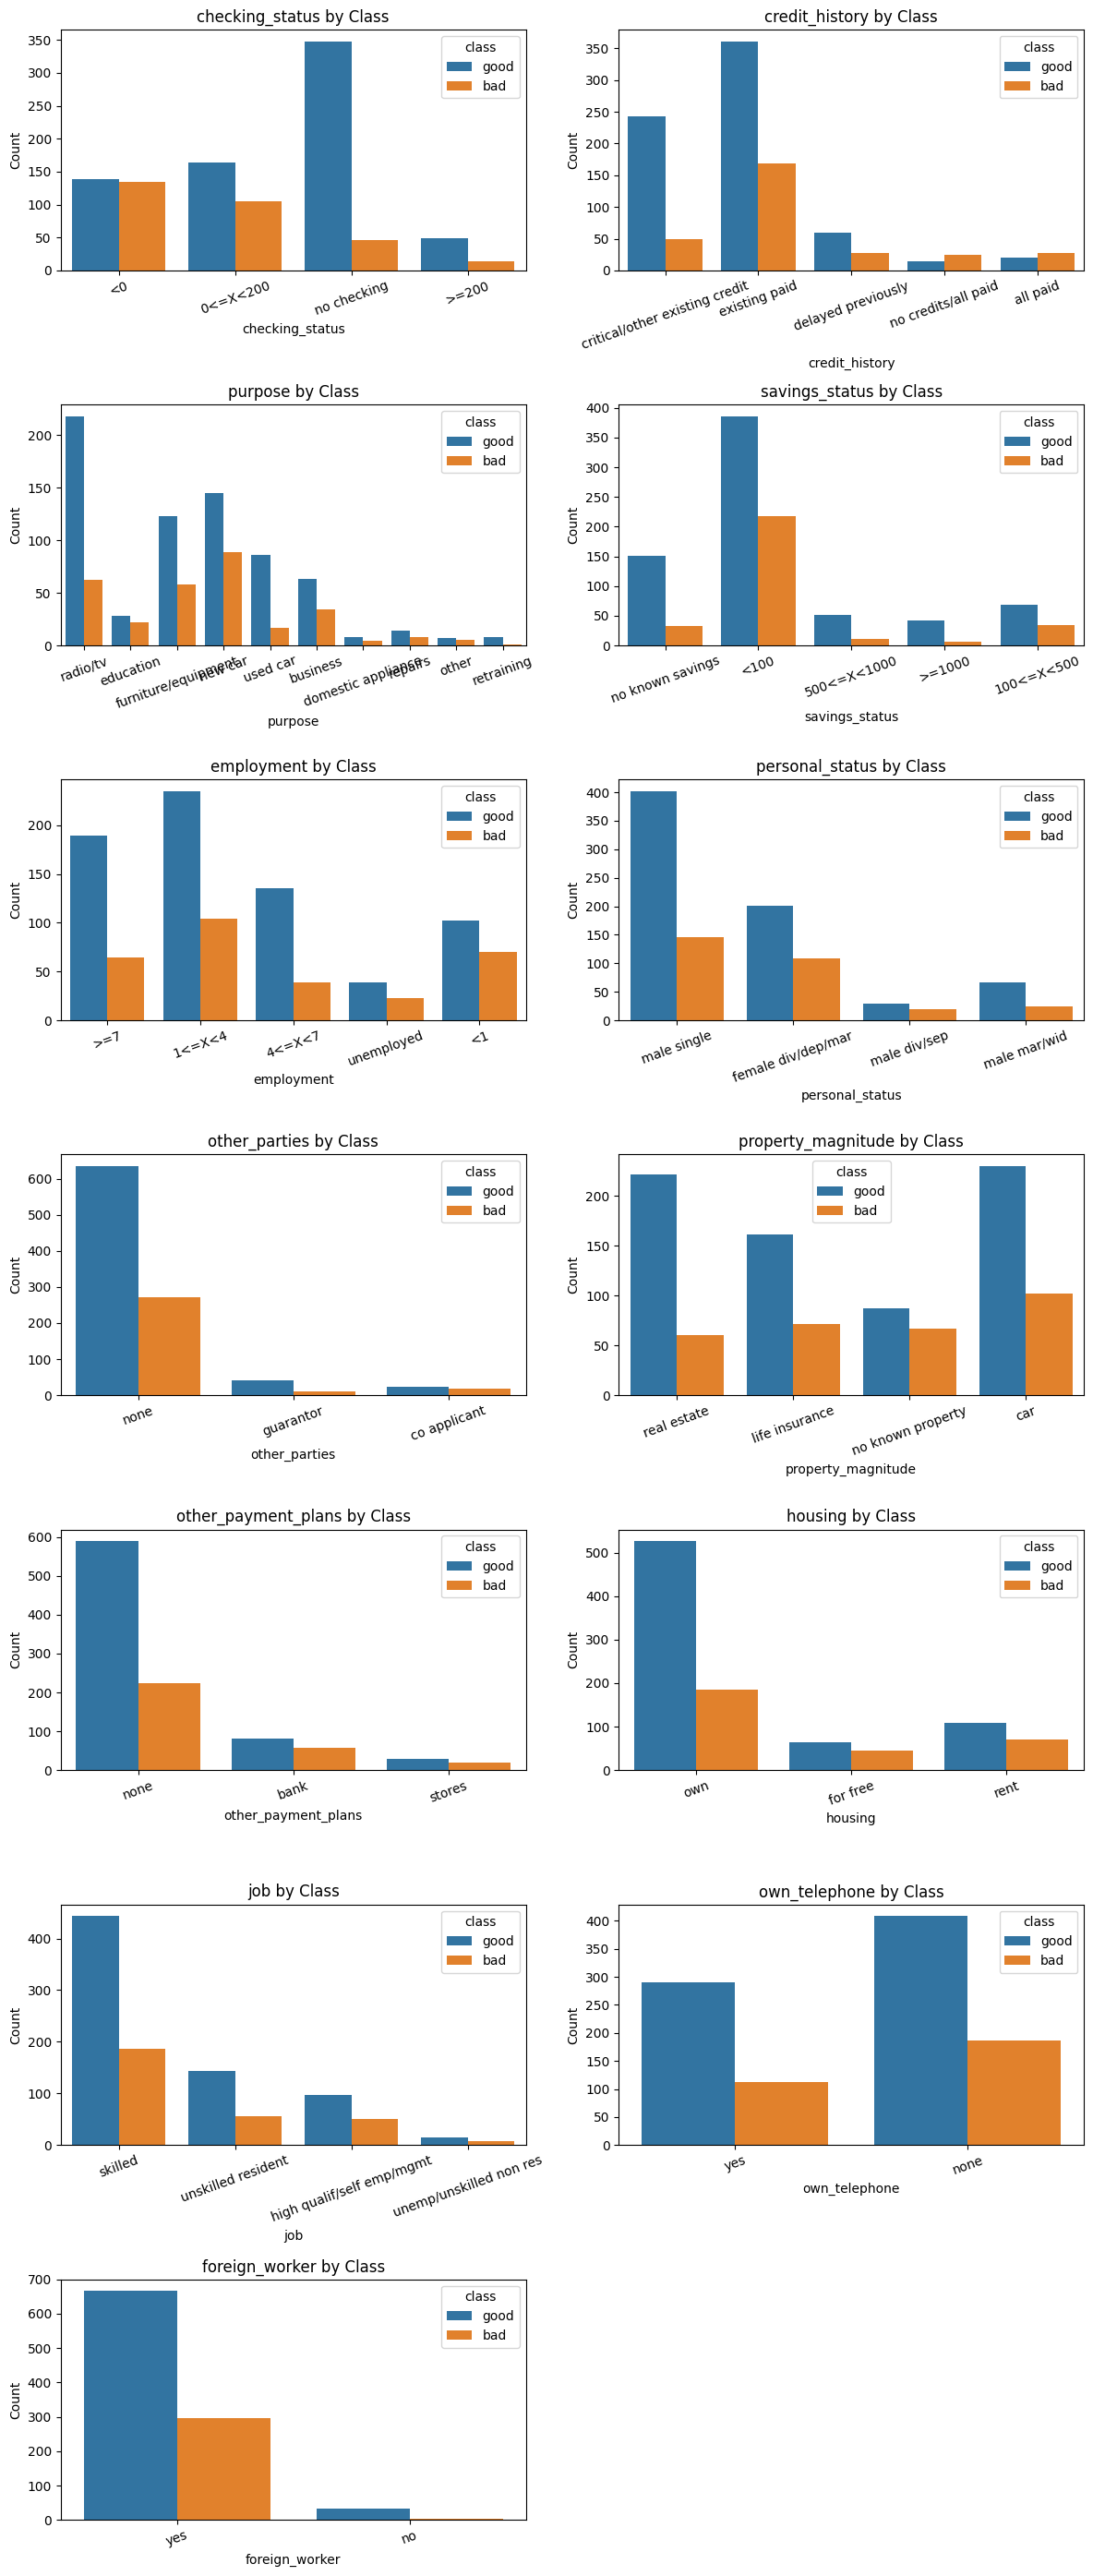

In [10]:
# Define the dimensions of the subplot grid
num_rows = 7
num_cols = 2

# Create the subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 28))

# Flatten the subplot grid to make it easier to iterate through
axs = axs.flatten()

# Loop through the list of categorical columns and create countplots
for i, col in enumerate(categorical_columns):
    axs[i].tick_params(axis='x', labelrotation=20)  # rotate x-axis labels
    sns.countplot(data=df, x=col, hue='class', ax=axs[i])
    axs[i].set_title(f'{col} by Class')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Count')

# Hide any unused subplots
for j in range(num_rows * num_cols):
    if j >= len(categorical_columns):
        axs[j].axis('off')

plt.tight_layout()
plt.show()

**Numerical features**

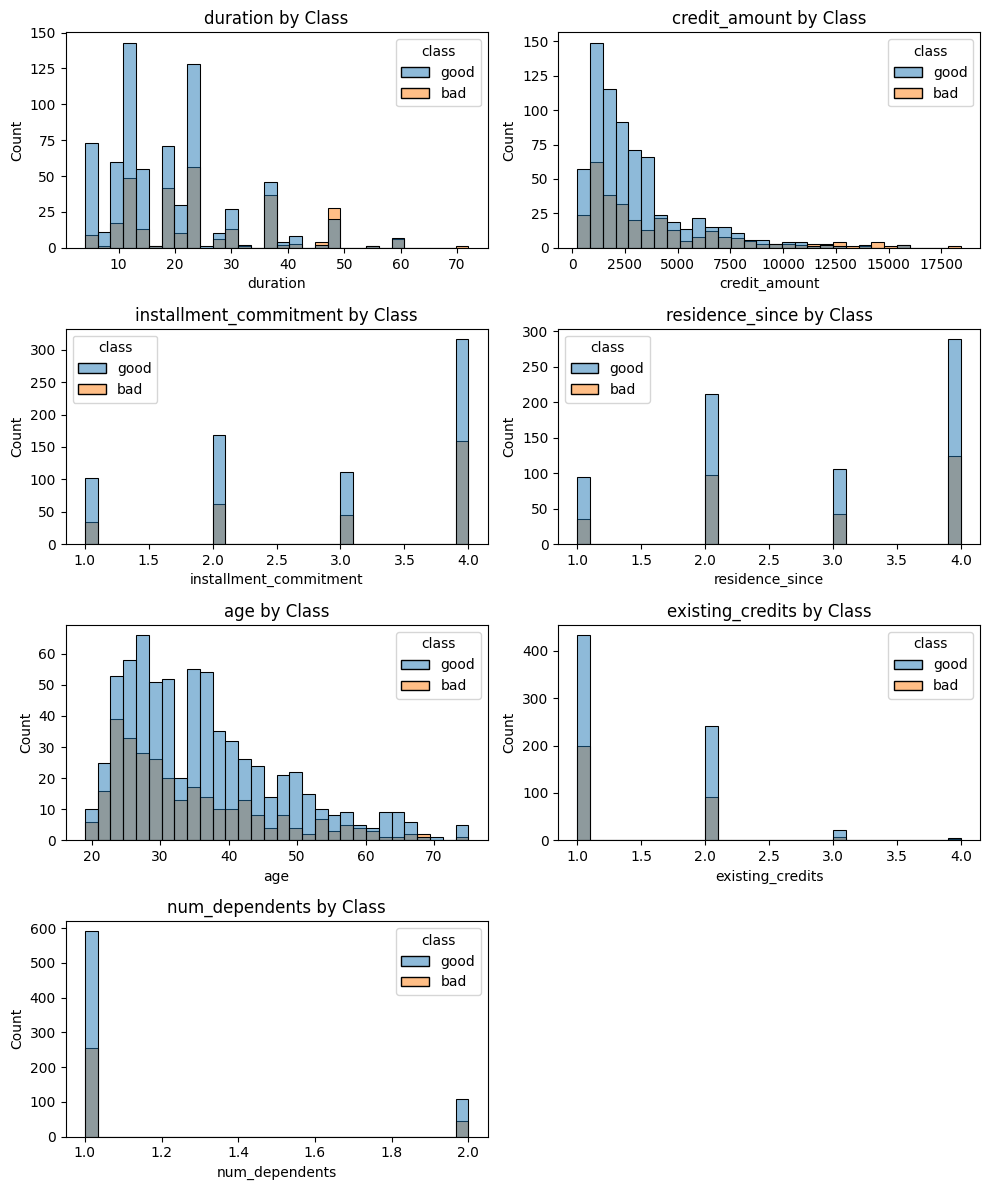

In [11]:
numerical_columns = ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age',
                    'existing_credits', 'num_dependents']
# Define the dimensions of the subplot grid
num_rows = 4
num_cols = 2

# Create the subplot grid with a taller figure size
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 12))

# Flatten the subplot grid to make it easier to iterate through
axs = axs.flatten()

# Loop through the list of numerical columns and create histograms
for i, col in enumerate(numerical_columns):
    sns.histplot(data=df, x=col, hue='class', bins=30, ax=axs[i])
    axs[i].set_title(f'{col} by Class')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Count')

# Hide any unused subplots
for j in range(num_rows * num_cols):
    if j >= len(numerical_columns):
        axs[j].axis('off')

plt.tight_layout()
plt.show()

# Feature Engineering

Better features make better models

**Age**

In [12]:
# New features for age buckets
df.loc[(df['age']>=18) & (df['age']<=25),'Age_group']='Age_18-25'
df.loc[(df['age']>25) & (df['age']<=30),'Age_group']='Age_26-30'
df.loc[(df['age']>30) & (df['age']<=50),'Age_group']='Age_31-50'
df.loc[df['age']>50,'Age_group']='Age_51+'

Text(0.5, 1.0, 'Age group distribution')

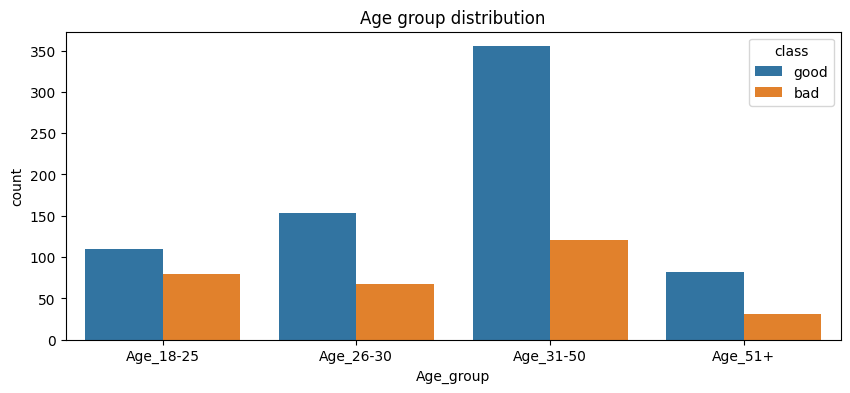

In [13]:
# Plot distribution of new features
plt.figure(figsize=(10,4))
g=sns.countplot(data=df, x='Age_group', hue='class', order=['Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Age group distribution')

**Duration**

In [14]:
df['duration'].value_counts().head(10)

24.0    184
12.0    179
18.0    113
36.0     83
6.0      75
15.0     64
9.0      49
48.0     48
30.0     40
21.0     30
Name: duration, dtype: int64

<AxesSubplot: xlabel='duration', ylabel='count'>

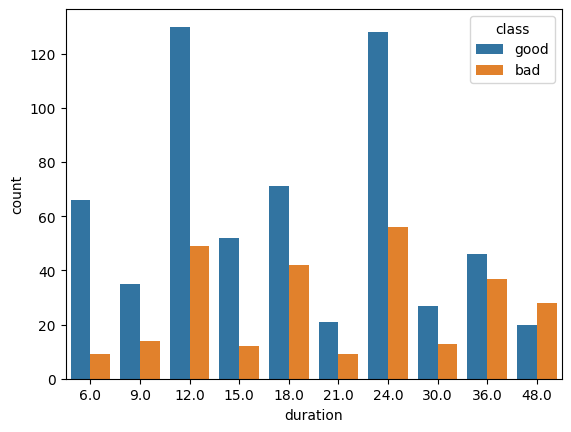

In [15]:
# Showing the 10 mst frequent Durations
frequent_durations = df['duration'].value_counts().nlargest(10).index.tolist()
sns.countplot(data=df[df['duration'].isin(frequent_durations)], x='duration', hue='class')

The shorter durations seem to have a higher proportion of good potential creditors

In [16]:
# Define a function to convert duration to binary categories
def duration_to_binary(duration):
    if duration > 31:
        return 'long'
    else:
        return 'short'

# Create a new column 'duration_binary' using the 'duration' column and the defined function
df['duration_binary'] = df['duration'].apply(duration_to_binary)

<AxesSubplot: xlabel='duration_binary', ylabel='count'>

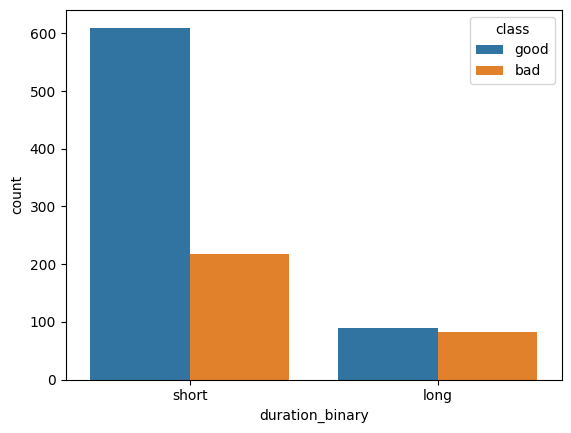

In [17]:
sns.countplot(data=df, x='duration_binary', hue='class')

# Dealing with null values

This dataset happens to have no nulls values

If there were nulls, some possible strategies 
- Remove rows that have many nulls
- Impute the median/mode value for that column into the null value
- If a row has many columns that are not null, and only a few columns that are null, use other rows which have similar overall data and are not null in the column of interest, as a best approximtion of what value to fill in

# Data Preprocessing

In [18]:
X = df.drop('class', axis=1)
X_processed = X.copy()

In [19]:
print(min(X_processed['duration']))
print(min(X_processed['age']))
print(min(X_processed['credit_amount']))

4.0
19.0
250.0


In [20]:
# Perform a log transformation on skewed numerical variables
# No zero or negative values, so no need to add a constant
log_columns = ['duration', 'age', 'credit_amount']
X_processed[log_columns] = np.log(X_processed[log_columns])

In [21]:
# One Hot Encoding on categorical variables
categorical_columns.extend(['Age_group', 'duration_binary'])
for col in categorical_columns:
    one_hot = pd.get_dummies(X_processed[col], prefix=col)
    X_processed = pd.concat([X_processed, one_hot], axis=1)
    X_processed.drop(col, axis=1, inplace=True)

In [22]:
# USing a standard scaler on numerical variables
from sklearn.preprocessing import StandardScaler
X_scaled = X_processed.copy()
scaler = StandardScaler()
scaler.fit(X_scaled[numerical_columns])
X_scaled[numerical_columns] = scaler.transform(X_scaled[numerical_columns])

# Model Baselines

Use models with default parameters
- logistic regression
- KNN
- Decision Tree
- Random Forest
- XGBoost
- SCM
- Naive Bayes

In [23]:
# Changing column names so that XGBoost accepts formatting
X_scaled = X_scaled.rename(columns=lambda x: x.replace('<', '-').replace('>', '-'))

In [24]:
# Split X and y into training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['class'].replace({'good': 1, 'bad': 0}), test_size=0.2, random_state=42)


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [26]:
lm = LinearRegression()
cv = cross_val_score(lm,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.22740725 0.10207932 0.08485378 0.27803689 0.13063096]
0.1646016383694459


In [27]:
kn = KNeighborsClassifier()
cv = cross_val_score(kn, X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.7375  0.69375 0.75    0.74375 0.75   ]
0.735


In [28]:
dt = DecisionTreeClassifier()
cv = cross_val_score(dt, X_train,y_train, cv=5)
print(cv)
print(cv.mean())

[0.68125 0.63125 0.68125 0.69375 0.68125]
0.67375


In [29]:
rf = RandomForestClassifier()
cv = cross_val_score(rf,X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.75    0.7375  0.74375 0.775   0.75   ]
0.75125


In [30]:
xgb = XGBClassifier()
cv = cross_val_score(xgb, X_train, y_train, cv = 5)
print(cv)
print(cv.mean())

[0.74375 0.71875 0.73125 0.73125 0.70625]
0.72625


In [31]:
nb = GaussianNB()
cv = cross_val_score(nb, X_train, y_train, cv = 5)
print(cv)
print(cv.mean())

[0.73125 0.725   0.425   0.75    0.69375]
0.6649999999999999


In [32]:
svc = SVC()
cv = cross_val_score(svc, X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.7375  0.74375 0.74375 0.78125 0.74375]
0.75


In [33]:
lgb = LGBMClassifier()
cv = cross_val_score(lgb, X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.7375  0.725   0.73125 0.75    0.70625]
0.7299999999999999


In [34]:
cb = CatBoostClassifier(silent=True)
cv = cross_val_score(cb, X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.75    0.75625 0.7375  0.75625 0.725  ]
0.7450000000000001


# Hyperparameter Tuning

Tuning parameters on the most promising models

In [35]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [36]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train,y_train)
print(best_clf_knn.best_score_)
print(best_clf_knn.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
0.74875
{'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


In [37]:
# rf = RandomForestClassifier(random_state = 1)
# param_grid =  {'n_estimators': [100,500,1000], 
#                                   'bootstrap': [True,False],
#                                   'max_depth': [3,5,10,20,50,75,100,None],
#                                   'min_samples_leaf': [1,2,4,10],
#                                   'min_samples_split': [2,5,10]}
                                  
# clf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
# best_clf_rf_rnd = clf_rf_rnd.fit(X_train,y_train)
# print(best_clf_rf_rnd.best_score_)
# print(best_clf_rf_rnd.best_params_)

0.76125
{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}

In [38]:
# svc = SVC(probability = True)
# param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
#                                   'C': [.1, 1, 10, 100, 1000]},
#                                  {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
#                                  {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
# clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
# best_clf_svc = clf_svc.fit(X_train,y_train)
# print(best_clf_svc.best_score_)
# print(best_clf_svc.best_params_)

Fitting 5 folds for each of 55 candidates, totalling 275 fits
0.7525
{'C': 1, 'degree': 3, 'kernel': 'poly'}

# Generating Predictions

Using the best performing model from parameter tuning (random forest)

In [39]:
rf = RandomForestClassifier(n_estimators= 500, min_samples_split= 5, min_samples_leaf= 1, 
                           max_features= 'auto', max_depth= 10, bootstrap= True)
rf.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=10, max_features='auto', min_samples_split=5,
                       n_estimators=500)

In [40]:
rf_pred = rf.predict(X_test)

In [41]:
print(len(rf_pred))
print(len(y_test))

200
200


In [42]:
total_predictions = len(rf_pred)
total_correct = 0
for x in range(total_predictions):
    if rf_pred[x] == y_test.values[x]:
        total_correct +=1
total_correct / total_predictions
        

0.78

# Random Forest Algorithm with optimal parameters uses these 20 metrics to correctly predict the credit evaluation 76.5% of the time